## Lasso Regression

We will try to fit the dataset with a Lasso Regression model. The steps are 

- Implement the Shooting Algorithm
 * allow for random or non-random order for the coordinates
 * allow for initial weights all zero or the corresponding solution to Ridge Regression
- Determine a class for the model supporting methods
 * fit 
 * predict 
 * score
- Tune hyperparameters
 * Search for hyperparameters through trial and error
 * Use upper bound on hyperparameter with warm start
- Plot the distributions of weight on the features 
 * Does Lasso Regression give us sparsity
- Threshold the values to compare zero/non-zero against the weights of the target function
- Implement Projected Gradient Descent 
 * Compare to Shooting Algorithm

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix

from load_data import load_problem

PICKLE_PATH = 'lasso_data.pickle'

#### Dataset

In [2]:
#load data 

x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_train = featurize(x_train)
X_val = featurize(x_val)

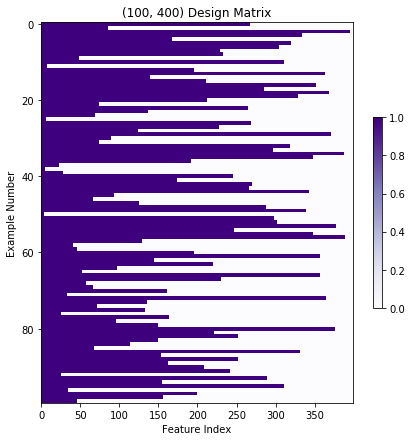

In [3]:
#Visualize training data

fig, ax = plt.subplots(figsize = (7,7))
ax.set_title("({0}, {1}) Design Matrix".format(X_train.shape[0], X_train.shape[1]))
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
temp = ax.imshow(X_train, cmap=plt.cm.Purples, aspect="auto")
plt.colorbar(temp, shrink=0.5);

In [4]:
def soft_threshold(a, delta):
    if a < - delta:
        return (a + delta)
    elif a > delta:
        return (a - delta)
    else: 
        return 0
    
def compute_sum_sqr_loss(X, y, w):
    return np.dot((np.dot(X,w)-y).T,np.dot(X,w)-y)
    
def compute_lasso_objective(X, y, w, l1_reg=0):
    return np.dot((np.dot(X,w)-y).T,np.dot(X,w)-y) + l1_reg*np.sum(np.abs(w))
    
def get_ridge_solution(X, y, l2_reg):
    return np.dot(np.linalg.inv(np.dot(X.T,X)+l2_reg*np.eye(X.shape[1])),np.dot(X.T,y))

Remember that we should avoid loops in the implementation because we need to run the algorithm repeatedly for hyperparameter tuning.

Please see Lecture 4 notes for derivation of shooting algorithm.

## Q1

$$a_j = 2X_{.j}^TX_{.j}$$
$$c_j = 2X_{.j}^T(y-Xw+w_jX_{.j})$$

## Q2

In [5]:
def shooting_algorithm(X, y, w0=None, l1_reg = 1., max_num_epochs = 1000, min_obj_decrease=1e-8, random=False):
    if w0 is None:
        w = np.zeros(X.shape[1])
    else:
        w = np.copy(w0)
    d = X.shape[1]
    epoch = 0
    obj_val = compute_lasso_objective(X, y, w, l1_reg)
    obj_decrease = min_obj_decrease + 1.
    while (obj_decrease>min_obj_decrease) and (epoch<max_num_epochs):
        obj_old = obj_val
        # Cyclic coordinates descent
        coordinates = range(d)
        # Randomized coordinates descent
        if random:
            coordinates = np.random.permutation(d)
        for j in coordinates:
            aj = 2*np.dot(X[:,j].T,X[:,j])
            cj = 2*np.dot(X[:,j].T,y-np.dot(X,w)+w[j]*X[:,j])
            w[j] = soft_threshold(cj/aj,l1_reg/aj)    
        obj_val = compute_lasso_objective(X, y, w, l1_reg)
        obj_decrease = obj_old - obj_val
        epoch += 1
    print("Ran for "+str(epoch)+" epochs. " + 'Lowest loss: ' + str(obj_val))
    return w, obj_val, epoch

In [6]:
randoms = [True,False]
regs = [1e-4,1e-2,1e-1,1,10,100]
ridge_solution = get_ridge_solution(X_train,y_train,l2_reg=0.01)
random_list = []
epoch_list = []
reg_list = []
loss_list = []
val_list = []
for random in randoms:
    for reg in regs:
        w, obj_val, epoch = shooting_algorithm(X_train, y_train, w0=None, l1_reg=reg, max_num_epochs=1000, min_obj_decrease=1e-8, random=random)
        val_loss = compute_sum_sqr_loss(X_val,y_val,w)
        random_list.append(random)
        epoch_list.append(epoch)
        loss_list.append(obj_val)
        val_list.append(val_loss)
        reg_list.append(reg)
df = pd.DataFrame({"random":random_list,"l1_reg":reg_list,"epoch":epoch_list,"obj function":loss_list,"val loss":val_list})
df        

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 1000 epochs. Lowest loss: 0.6798308598917894
Ran for 1000 epochs. Lowest loss: 1.085852696221787
Ran for 1000 epochs. Lowest loss: 3.97932878525749
Ran for 649 epochs. Lowest loss: 16.19773809673319
Ran for 568 epochs. Lowest loss: 56.81897672643175
Ran for 265 epochs. Lowest loss: 221.86396567518784
Ran for 1000 epochs. Lowest loss: 0.6789177209948681
Ran for 1000 epochs. Lowest loss: 1.042250022635014
Ran for 1000 epochs. Lowest loss: 3.9049775016337263
Ran for 824 epochs. Lowest loss: 16.19773797187303
Ran for 742 epochs. Lowest loss: 56.81897663333593
Ran for 732 epochs. Lowest loss: 221.86396593376537


,random,l1_reg,epoch,obj function,val loss
0,True,0.0001,1000,0.679831,161.199238
1,True,0.0100,1000,1.085853,169.743510
2,True,0.1000,1000,3.979329,152.934274
3,True,1.0000,649,16.197738,137.242037
4,True,10.0000,568,56.818977,179.330099
5,True,100.0000,265,221.863966,757.209712
6,False,0.0001,1000,0.678918,205.219387
7,False,0.0100,1000,1.042250,202.856209
8,False,0.1000,1000,3.904978,185.525278
9,False,1.0000,824,16.197738,151.037437


As we can see from the table above, if we initialize w to be 0's, randomization with lambda=1 gives the best result 

In [7]:
randoms = [True,False]
regs = [1e-4,1e-2,1e-1,1,10,100]
ridge_solution = get_ridge_solution(X_train,y_train,l2_reg=0.01)
random_list = []
epoch_list = []
reg_list = []
loss_list = []
val_list = []
for random in randoms:
    for reg in regs:
        w, obj_val, epoch = shooting_algorithm(X_train, y_train, w0=ridge_solution, l1_reg=reg, max_num_epochs=1000, min_obj_decrease=1e-8, random=random)
        val_loss = compute_sum_sqr_loss(X_val,y_val,w)
        random_list.append(random)
        epoch_list.append(epoch)
        loss_list.append(obj_val)
        val_list.append(val_loss)
        reg_list.append(reg)
df = pd.DataFrame({"random":random_list,"l1_reg":reg_list,"epoch":epoch_list,"obj function":loss_list,"val loss":val_list})
df

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 579 epochs. Lowest loss: 0.6789110289549598
Ran for 534 epochs. Lowest loss: 1.0422438166565553
Ran for 1000 epochs. Lowest loss: 3.9049764100901316
Ran for 629 epochs. Lowest loss: 16.197738065777575
Ran for 682 epochs. Lowest loss: 56.81897673111054
Ran for 252 epochs. Lowest loss: 221.86396619400932
Ran for 486 epochs. Lowest loss: 0.6789105182730852
Ran for 571 epochs. Lowest loss: 1.0422432500360437
Ran for 880 epochs. Lowest loss: 3.9049739068639173
Ran for 720 epochs. Lowest loss: 16.197737980794297
Ran for 878 epochs. Lowest loss: 56.818976564156834
Ran for 836 epochs. Lowest loss: 221.8639658706465


,random,l1_reg,epoch,obj function,val loss
0,True,0.0001,579,0.678911,155.311948
1,True,0.0100,534,1.042244,153.901668
2,True,0.1000,1000,3.904976,143.002751
3,True,1.0000,629,16.197738,112.229370
4,True,10.0000,682,56.818977,174.465633
5,True,100.0000,252,221.863966,761.061837
6,False,0.0001,486,0.678911,155.264592
7,False,0.0100,571,1.042243,154.268559
8,False,0.1000,880,3.904974,146.794280
9,False,1.0000,720,16.197738,111.072406


As we can see from the table above, if we initialize w to be the ridge solution, no randomization with lambda=1 gives the best result on the test set, and all losses seem to be lower compared to same setup but with $w_0 = \vec{0}.$

## Q3

#### Class for Lasso Regression 

In [8]:
class LassoRegression(BaseEstimator, RegressorMixin):
    """ Lasso regression"""
    def __init__(self, l1_reg=1.0, randomized=False):
        if l1_reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1_reg = l1_reg
        self.randomized = randomized


    def fit(self, X, y, max_epochs = 1000, coef_init=None):
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        if coef_init is None:
            coef_init = get_ridge_solution(X,y, self.l1_reg)
        
        self.w_, obj_val, epoch = shooting_algorithm(X, y, w0=coef_init, l1_reg=self.l1_reg, max_num_epochs=max_epochs, min_obj_decrease=1e-8, random=self.randomized)
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return np.dot(X, self.w_)

    def score(self, X, y):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return compute_sum_sqr_loss(X, y, self.w_)/len(y)

We can compare to the `sklearn` implementation.

In [9]:
def compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1):
    
    # Fit with sklearn -- need to multiply l1_reg by 2*sample size, since they
    # use a slightly different objective function.
    n = X_train.shape[0]
    sklearn_lasso = Lasso(alpha=2*n*l1_reg, fit_intercept=False, normalize=False)
    sklearn_lasso.fit(X_train, y_train)
    sklearn_lasso_coefs = sklearn_lasso.coef_
    sklearn_lasso_preds = sklearn_lasso.predict(X_train)

    # Now run our lasso regression and compare the coefficients to sklearn's
    
    model = LassoRegression(randomized=True)
    model.fit(X_train, y_train,coef_init=None)
    our_coefs = model.w_
    lasso_regression_preds = model.predict(X_train)

    # Let's compare differences in predictions
    print("Hoping this is very close to 0 (predictions): {}".format( np.mean((sklearn_lasso_preds - lasso_regression_preds)**2)))
    # Let's compare differences parameter values
    print("Hoping this is very close to 0: {}".format(np.sum((our_coefs - sklearn_lasso_coefs)**2)))

In [10]:
compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1)

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 662 epochs. Lowest loss: 16.19773806585367
Hoping this is very close to 0 (predictions): 3.4346941284451464
Hoping this is very close to 0: 1.504649071501123


#### Grid Search to Tune Hyperparameter

Now let's use sklearn to help us do hyperparameter tuning
GridSearchCv.fit by default splits the data into training and
validation itself; we want to use our own splits, so we need to stack our
training and validation sets together, and supply an index
(validation_fold) to specify which entries are train and which are
validation.

In [11]:
default_params = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 1.3, 1.6, 1.9, 2.2, 2.5, 2.8]

def do_grid_search_lasso(X_train, y_train, X_val, y_val,params = default_params):
	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'l1_reg':params}]

	lasso_regression_estimator = LassoRegression(randomized=True)
	grid = GridSearchCV(lasso_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l1_reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l1_reg"])
	return grid, df_toshow

In [12]:
grid, results = do_grid_search_lasso(X_train, y_train, X_val, y_val)

Ran for 1 epochs. Lowest loss: 0.6752223426032413


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 1 epochs. Lowest loss: 0.6755576054044078
Ran for 10 epochs. Lowest loss: 0.6789098853912399


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 141 epochs. Lowest loss: 0.7123821721344291


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 545 epochs. Lowest loss: 1.0422438085622936


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 965 epochs. Lowest loss: 3.9049742926436295


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 646 epochs. Lowest loss: 16.19773804234723


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 663 epochs. Lowest loss: 18.20873769299461


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 646 epochs. Lowest loss: 20.146332086459903


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 674 epochs. Lowest loss: 22.016046580608936


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 638 epochs. Lowest loss: 23.818255203736737


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 658 epochs. Lowest loss: 25.559311005849157


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 643 epochs. Lowest loss: 27.242934055616693
Ran for 1000 epochs. Lowest loss: 92.81070262473658


In [13]:
results

,param_l1_reg,mean_test_score,mean_train_score
0,0.000001,0.172590,0.006752
1,0.000010,0.172589,0.006752
2,0.000100,0.172574,0.006752
3,0.001000,0.172423,0.006752
4,0.010000,0.170939,0.006805
5,0.100000,0.158959,0.011139
6,1.000000,0.126981,0.091950
7,1.300000,0.124774,0.096655
8,1.600000,0.126586,0.099935
9,1.900000,0.127556,0.103894


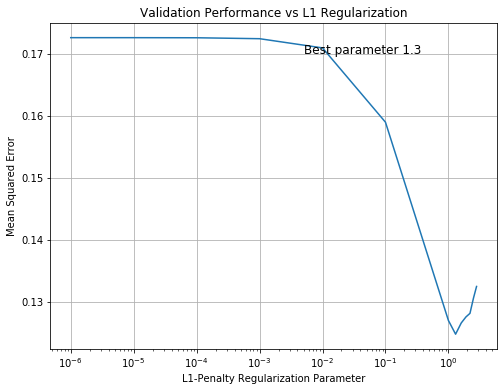

In [14]:
# Plot validation performance vs regularization parameter

fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

ax.semilogx(results["param_l1_reg"], results["mean_test_score"])

ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l1_reg']), fontsize = 12);

As we can see, the best parameter is 1 with ridge solution initialization and randomization.

#### Comparing to the Target Function

Let's plot prediction functions and compare coefficients for several fits and the target function.


Let's create a list of dicts called `pred_fns`. Each dict has a "name" key and a
"preds" key. The value corresponding to the "preds" key is an array of
predictions corresponding to the input vector x. x_train and y_train are
the input and output values for the training data

In [15]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l1regs = [0.1, grid.best_params_['l1_reg'], 1]
X = featurize(x)
for l1reg in l1regs:
    lasso_regression_estimator = LassoRegression(l1_reg=l1reg)
    lasso_regression_estimator.fit(X_train, y_train)
    name = "Lasso with L1Reg="+str(l1reg)
    pred_fns.append({"name":name,
                     "coefs":lasso_regression_estimator.w_,
                     "preds": lasso_regression_estimator.predict(X) })

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 830 epochs. Lowest loss: 3.9049738772510736
Ran for 717 epochs. Lowest loss: 18.208737675700142
Ran for 730 epochs. Lowest loss: 16.19773806144752


In [16]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

	fig, ax = plt.subplots(figsize = (12,8))
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, color="k", label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

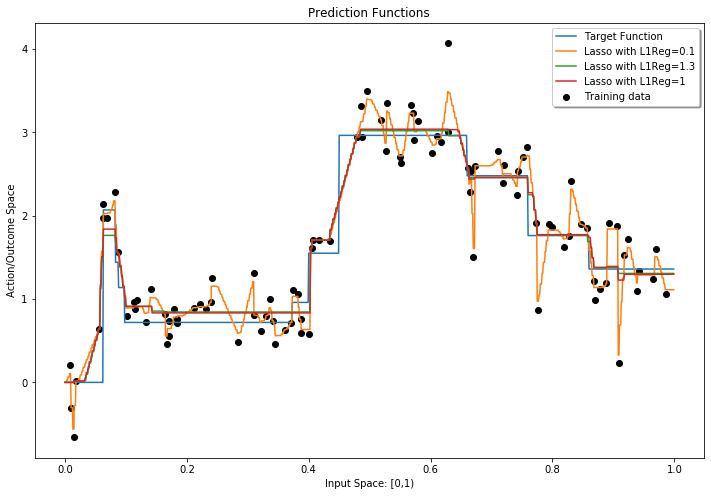

In [17]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best");

#### Visualizing the Weights

Using `pred_fns` let's try to see how sparse the weights are... 

In [18]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

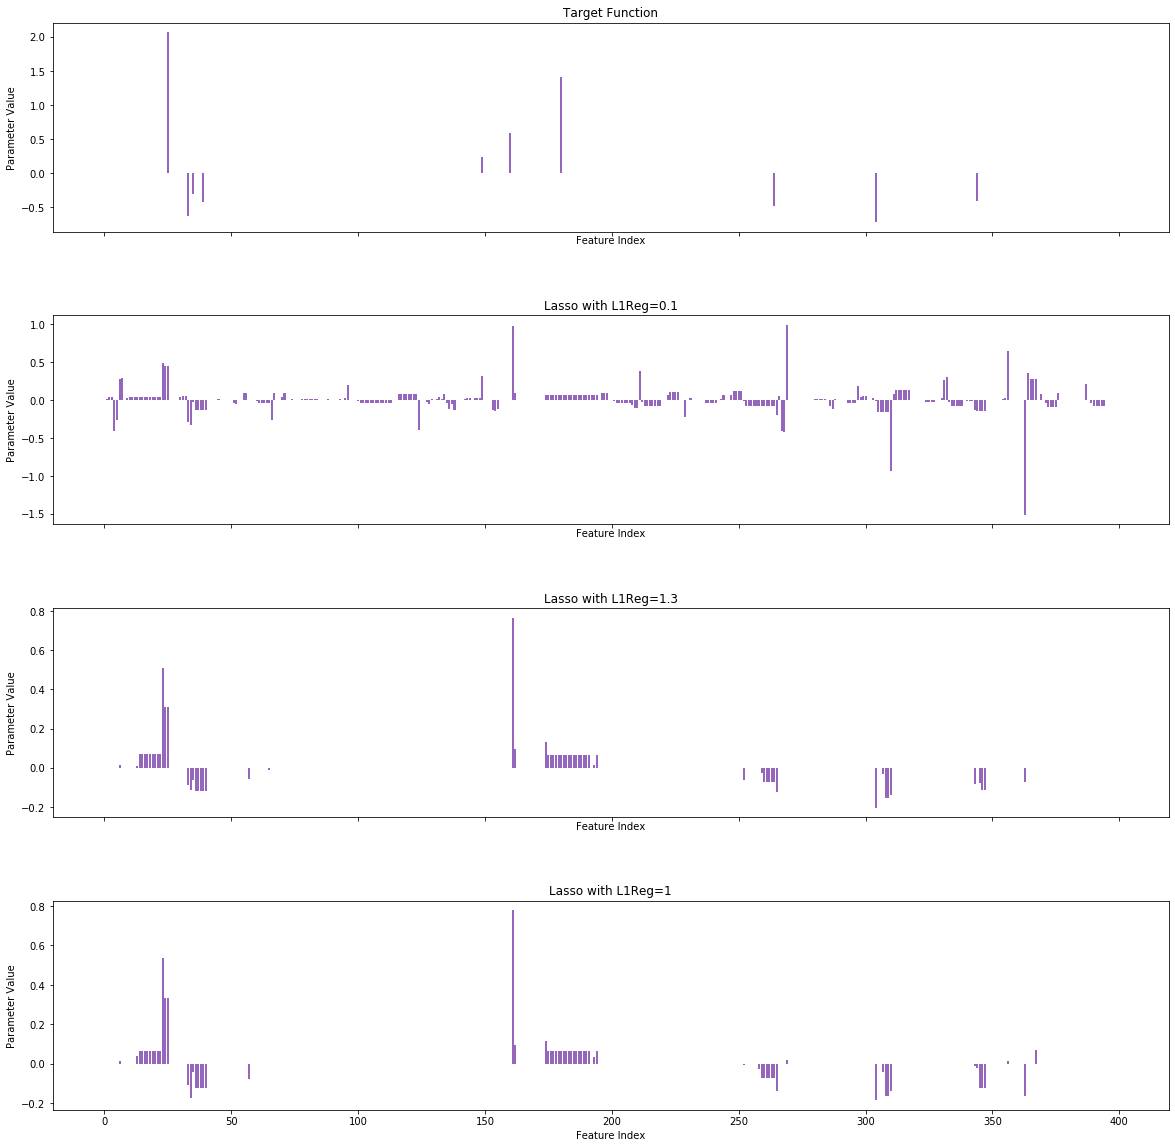

In [19]:
compare_parameter_vectors(pred_fns);

As we can see, as l1_reg becomes larger, more and more features become 0's. This confirms that lasso regularization can be used as feauture selection as it removes the weights of the useless feautures according to the regularization parameter.

## Q4

#### Continuation Method

We compute the largest value of $\lambda$ for which the weights can be nonzero.

In [8]:
def get_lambda_max_no_bias(X, y):
    return 2 * np.max(np.abs(np.dot(y, X)))

Use homotopy method to compute regularization path for LassoRegression.

In [21]:
from sklearn.base import clone

class LassoRegularizationPath:
    def __init__(self, estimator, tune_param_name):
        self.estimator = estimator
        self.tune_param_name = tune_param_name

    def fit(self, X, y, reg_vals, coef_init=None, warm_start=True):
        # reg_vals is a list of regularization parameter values to solve for.
        # Solutions will be found in the order given by reg_vals.

        #convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)

        if coef_init is not None:
            coef_init = np.copy(coef_init)

        self.results = []
        for reg_val in reg_vals:
            estimator = clone(self.estimator)
            w, obj_val, epoch = shooting_algorithm(X, y, w0=coef_init, l1_reg=reg_val)
            self.results.append({"reg_val":reg_val, "estimator":estimator,"weights":w})

        return self

    def predict(self, X, y=None):
        predictions = []
        for i in range(len(self.results)):
            preds = self.results[i]["estimator"].predict(X)
            reg_val = self.results[i]["reg_val"]
            predictions.append({"reg_val":reg_val, "preds":preds})
        return predictions

    def score(self, X, y=None):
        scores = []
        for i in range(len(self.results)):
            score = self.results[i]["estimator"].score(X, y)
            reg_val = self.results[i]["reg_val"]
            scores.append({"reg_val":reg_val, "score":score})
        return scores

In [22]:
def do_grid_search_homotopy(X_train, y_train, X_val, y_val,
                            reg_vals=None, w0=None):
    if reg_vals is None:
        lambda_max = get_lambda_max_no_bias(X_train, y_train)
        reg_vals = [lambda_max * (.8**n) for n in range(0, 30)]
    
    
    estimator = LassoRegression()
    lasso_reg_path_estimator = LassoRegularizationPath(estimator, tune_param_name="l1_reg")
    lasso_reg_path_estimator.fit(X_train, y_train,
                                 reg_vals=reg_vals[:], coef_init=w0,
                                 warm_start=True)
    return lasso_reg_path_estimator, reg_vals

In [23]:
lasso_reg_path_estimator, reg_vals = do_grid_search_homotopy(X_train, 
                                                             y_train, 
                                                             X_val, 
                                                             y_val, 
                                                             None)

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 1 epochs. Lowest loss: 359.6674002813196
Ran for 594 epochs. Lowest loss: 348.52108633392805
Ran for 653 epochs. Lowest loss: 323.5371648261513
Ran for 582 epochs. Lowest loss: 293.22926498817293
Ran for 732 epochs. Lowest loss: 262.2363733469605
Ran for 731 epochs. Lowest loss: 231.30364707665956
Ran for 733 epochs. Lowest loss: 202.0174855998118
Ran for 734 epochs. Lowest loss: 175.6829689439503
Ran for 736 epochs. Lowest loss: 152.73952248856375
Ran for 737 epochs. Lowest loss: 133.12872423056882
Ran for 737 epochs. Lowest loss: 116.62091784825118
Ran for 738 epochs. Lowest loss: 102.89040535085165
Ran for 739 epochs. Lowest loss: 91.40127989084868
Ran for 740 epochs. Lowest loss: 80.59513459352864
Ran for 741 epochs. Lowest loss: 70.6513115923515
Ran for 742 epochs. Lowest loss: 61.83896929177382
Ran for 743 epochs. Lowest loss: 54.081080014686314
Ran for 740 epochs. Lowest loss: 47.326669350039296
Ran for 731 epochs. Lowest loss: 41.56428608924523
Ran for 765 epochs. Lowes

Text(0.5, 1.0, 'average val loss')

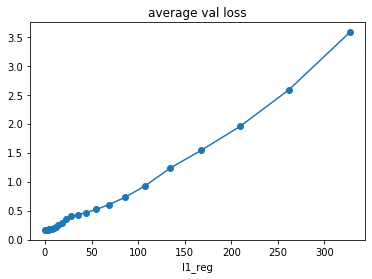

In [24]:
lasso_reg_path_estimator.results[0]
rs = []
losses = []
for dic in lasso_reg_path_estimator.results:
    rs.append(dic["reg_val"])
    losses.append(compute_sum_sqr_loss(X_val,y_val,dic["weights"])/X_val.shape[0])
    
plt.plot(rs,losses,"-o")
plt.xlabel("l1_reg")
plt.title("average val loss")

## Q5

In [25]:
# Add an unregularized bias term
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1)))) 
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))

In [26]:
l1_reg = 1.
l2_reg = 0.1

lasso = LassoRegression(l1_reg=l1_reg,randomized=True)
lasso.fit(X_train,y_train)
print("Avg val loss for L1: ", lasso.score(X_val,y_val))

ridge_sol = get_ridge_solution(X_train,y_train,l2_reg=l2_reg)
print("Avg val loss for L2: ", compute_sum_sqr_loss(X_val,y_val,ridge_sol)/X_val.shape[0])

/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 651 epochs. Lowest loss: 16.197738066251986
Avg val loss for L1:  0.12473404392083155
Avg val loss for L2:  0.1627421890227181


We can see that adding an unregularized bias term by padding 1's is having the same effect in terms of avg val loss value comparing to our original setup. This confirms that we have to “pay for” this offset using our penalized parameters.

In [27]:
ridge_sol[-1]

0.03160551307882997

For example in the ridge solution, we can see that the last weight ($w_{d+1}$) corresponding to the unregularized bias term is nonzero.

#### Projected SGD

## Q1

In [50]:
def projection_SGD_split(X, y, theta_positive_0, theta_negative_0, lambda_reg = 1.0, alpha = 0.1, num_iter = 1000):
    m, n = X.shape
    theta_positive = np.zeros(n)
    theta_negative = np.zeros(n)
    theta_positive[0:n] = theta_positive_0
    theta_negative[0:n] = theta_negative_0
    times = 0
    theta = theta_positive - theta_negative
    loss = compute_sum_sqr_loss(X, y, theta)/X.shape[0]
    loss_change = 1.
    while (loss_change>1e-6) and (times<num_iter):
        loss_old = loss
        for i in range(m):
            for j in range(n):
                if theta_positive[j]:
                    theta_positive[j] -= alpha*2*((np.dot(theta_positive-theta_negative,X[i])-y[i])*X[i][j]+lambda_reg) 
                else:
                    theta_positive[j] -= alpha*2*((np.dot(theta_positive-theta_negative,X[i])-y[i])*X[i][j])
                if theta_negative[j]:
                    theta_negative[j] -= alpha*2*((np.dot(theta_positive-theta_negative,X[i])-y[i])*(-X[i][j])+lambda_reg)
                else:
                    theta_negative[j] -= alpha*2*((np.dot(theta_positive-theta_negative,X[i])-y[i])*(-X[i][j]))
                
            #theta_positive -= alpha*2*(np.dot(theta_positive-theta_negative,X[i])-y[i])*X[i]
            #theta_negative -= alpha*2*(np.dot(theta_positive-theta_negative,X[i])-y[i])*-(X[i])
            np.clip(theta_positive, 0., None)
            np.clip(theta_negative, 0., None)
            theta = theta_positive - theta_negative
        loss = compute_sum_sqr_loss(X, y, theta)/X.shape[0]
        #print(loss)
        loss_change = loss_old - loss#np.abs(loss - loss_old)
        times +=1

    print('(SGD) Ran for {} epochs. Loss:{} Lambda: {}'.format(times,loss,lambda_reg))
    return theta



#theta_positive += -alpha*(2*np.dot(X.T,np.dot(X,theta_positive-theta_negative)-y)/X.shape[0] + np.array([lambda_reg if i else 0. for i in theta_positive]))
#theta_negative += -alpha*(2*np.dot(-X.T,np.dot(X,theta_positive-theta_negative)-y)/X.shape[0] + np.array([lambda_reg if i else 0. for i in theta_negative]))
#print(theta_positive)
#print(theta_negative)
#np.clip(theta_positive, 0., None)
#np.clip(theta_negative, 0., None)
#theta = theta_positive - theta_negative
#print(theta)

In [51]:
x_training, y_training, x_validation, y_validation, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_training = featurize(x_training)
X_validation = featurize(x_validation)
D = X_training.shape[1]

lambda_max = get_lambda_max_no_bias(x_training, y_training)
reg_vals = [lambda_max * (.6**n) for n in range(15, 25)]

loss_SGD_list = []
loss_shooting = []
loss_GD_list = []
    
for lambda_value in reg_vals:
    theta_projected =  projection_SGD_split(X_training, y_training, np.zeros(X_training.shape[1]), np.zeros(X_training.shape[1]), lambda_reg = lambda_value, alpha = 0.1, num_iter = 1000)
    loss_SGD_list.append(compute_sum_sqr_loss(X_validation,y_validation,theta_projected)/X_validation.shape[0])
    theta_shooting, _, _ = shooting_algorithm(X_training, y_training, w0=None, l1_reg = lambda_value, max_num_epochs = 1000, min_obj_decrease=1e-8, random=False)
    loss_shooting.append(compute_sum_sqr_loss(X_validation,y_validation,theta_shooting)/X_validation.shape[0])

(SGD) Ran for 30 epochs. Loss:1.402028509912859 Lambda: 0.08639124693688116


/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/envs/dsga-1003/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Ran for 1000 epochs. Lowest loss: 3.5178841123598166
(SGD) Ran for 31 epochs. Loss:1.3746442831273407 Lambda: 0.05183474816212869
Ran for 1000 epochs. Lowest loss: 2.4648530491515035
(SGD) Ran for 31 epochs. Loss:1.349870066287359 Lambda: 0.03110084889727721
Ran for 1000 epochs. Lowest loss: 1.781887325644532
(SGD) Ran for 31 epochs. Loss:1.3416890233973284 Lambda: 0.01866050933836633
Ran for 1000 epochs. Lowest loss: 1.3515108201528356
(SGD) Ran for 32 epochs. Loss:1.339546440418353 Lambda: 0.011196305603019797
Ran for 1000 epochs. Lowest loss: 1.0854433720625416
(SGD) Ran for 32 epochs. Loss:1.3354908978891746 Lambda: 0.006717783361811878
Ran for 1000 epochs. Lowest loss: 0.9229608309275833
(SGD) Ran for 32 epochs. Loss:1.3331566689934982 Lambda: 0.004030670017087127
Ran for 1000 epochs. Lowest loss: 0.8244451040361851
(SGD) Ran for 32 epochs. Loss:1.3317868975355374 Lambda: 0.0024184020102522756
Ran for 1000 epochs. Lowest loss: 0.7649593498421838
(SGD) Ran for 32 epochs. Loss:1.330

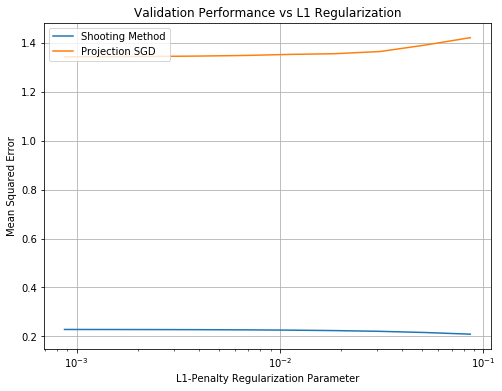

In [52]:
# Plot validation performance vs regularization parameter

fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

plt.semilogx(reg_vals, loss_shooting, label = 'Shooting Method')
plt.semilogx(reg_vals, loss_SGD_list, label = 'Projection SGD')
plt.legend(loc='upper left')
plt.show();

In [53]:
# Report the best 

lambda_best_SGD = reg_vals[np.argmin(loss_SGD_list)]
theta_lasso_SGD_best = projection_SGD_split(X_training, y_training, theta_positive_ini, theta_negative_ini, lambda_reg=lambda_best_SGD, alpha = 0.01)
print('Best lambda for SGD is {0} with loss {1}'.format(lambda_best_SGD, np.min(loss_SGD_list)))

NameError: name 'theta_positive_ini' is not defined